In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.stats import norm

In [2]:
nodes = pd.read_csv("../data/nodes.csv")
nodes


,# index,name,code,region,sub_region,_pos
0,0,Afghanistan,4,Asia,Southern Asia,"array([1.83174148, 1.86242262])"
1,1,Albania,8,Europe,Southern Europe,"array([1.89105956, 2.05459683])"
2,2,Algeria,12,Africa,Northern Africa,"array([1.90130528, 1.98917661])"
3,3,American Samoa,16,Oceania,Polynesia,"array([1.97167436, 2.13972604])"
4,4,Andorra,20,Europe,Southern Europe,"array([1.70167317, 1.89743272])"
...,...,...,...,...,...,...
227,227,Wallis and Futuna Islands,876,Oceania,Polynesia,"array([1.79672158, 2.22175723])"
228,228,Western Sahara,732,Africa,Northern Africa,"array([2.01706011, 1.86488782])"
229,229,Yemen,887,Asia,Western Asia,"array([1.92891113, 1.97069976])"
230,230,Zambia,894,Africa,Eastern Africa,"array([1.94272176, 1.93080904])"


In [3]:
nodes.drop(nodes.columns[[0, 5]], axis=1, inplace=True)
nodes.columns = nodes.columns.str.lstrip()
nodes

,name,code,region,sub_region
0,Afghanistan,4,Asia,Southern Asia
1,Albania,8,Europe,Southern Europe
2,Algeria,12,Africa,Northern Africa
3,American Samoa,16,Oceania,Polynesia
4,Andorra,20,Europe,Southern Europe
...,...,...,...,...
227,Wallis and Futuna Islands,876,Oceania,Polynesia
228,Western Sahara,732,Africa,Northern Africa
229,Yemen,887,Asia,Western Asia
230,Zambia,894,Africa,Eastern Africa


In [4]:
rows_as_dicts = nodes.to_dict('index')
rows_as_dicts

{0: {'name': 'Afghanistan',
  'code': 4,
  'region': 'Asia',
  'sub_region': 'Southern Asia'},
 1: {'name': 'Albania',
  'code': 8,
  'region': 'Europe',
  'sub_region': 'Southern Europe'},
 2: {'name': 'Algeria',
  'code': 12,
  'region': 'Africa',
  'sub_region': 'Northern Africa'},
 3: {'name': 'American Samoa',
  'code': 16,
  'region': 'Oceania',
  'sub_region': 'Polynesia'},
 4: {'name': 'Andorra',
  'code': 20,
  'region': 'Europe',
  'sub_region': 'Southern Europe'},
 5: {'name': 'Angola',
  'code': 24,
  'region': 'Africa',
  'sub_region': 'Middle Africa'},
 6: {'name': 'Anguilla',
  'code': 660,
  'region': 'Latin America and the Caribbean',
  'sub_region': 'Caribbean'},
 7: {'name': 'Antigua and Barbuda',
  'code': 28,
  'region': 'Latin America and the Caribbean',
  'sub_region': 'Caribbean'},
 8: {'name': 'Argentina',
  'code': 32,
  'region': 'Latin America and the Caribbean',
  'sub_region': 'South America'},
 9: {'name': 'Armenia',
  'code': 51,
  'region': 'Asia',
  's

In [5]:
g = nx.DiGraph()

In [6]:
for i, attrs in rows_as_dicts.items():
    g.add_node(i, **attrs)

In [7]:
edges = pd.read_csv("../data/edges.csv")
edges

,# source,target,migration_1990_total,migration_1990_male,migration_1990_female,migration_1995_total,migration_1995_male,migration_1995_female,migration_2000_total,migration_2000_male,migration_2000_female,migration_2005_total,migration_2005_male,migration_2005_female,migration_2010_total,migration_2010_male,migration_2010_female,migration_2015_total,migration_2015_male,migration_2015_female
0,0,64,237,194,43,188,150,38,154,117,37,183,142,41,198,152,46,235,173,62
1,0,118,677,556,121,452,351,101,236,155,81,259,187,72,284,206,78,320,231,89
2,0,142,64,26,38,61,25,36,58,23,35,45,18,27,43,18,25,39,17,22
3,0,191,59,37,22,36,24,12,30,20,10,47,27,20,69,41,28,83,50,33
4,0,202,8485,3726,4759,12248,5518,6730,17118,7874,9244,12636,5687,6949,8900,3906,4994,7587,3279,4308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11223,231,220,4767,2148,2619,7571,3451,4120,10686,4909,5777,26585,12282,14303,42811,19381,23430,50001,22556,27445
11224,231,11,8265,4184,4081,10498,5291,5207,12110,6110,6000,21690,10960,10730,33720,16870,16850,38843,19418,19425
11225,231,147,676,323,353,822,398,424,2807,1365,1442,7794,3783,4011,8170,3959,4211,8416,4070,4346
11226,231,68,0,0,0,0,0,0,0,0,0,0,0,0,6,6,0,6,6,0


In [8]:
edges.rename(columns={edges.columns[0]: 'source'}, inplace=True)
edges

,source,target,migration_1990_total,migration_1990_male,migration_1990_female,migration_1995_total,migration_1995_male,migration_1995_female,migration_2000_total,migration_2000_male,migration_2000_female,migration_2005_total,migration_2005_male,migration_2005_female,migration_2010_total,migration_2010_male,migration_2010_female,migration_2015_total,migration_2015_male,migration_2015_female
0,0,64,237,194,43,188,150,38,154,117,37,183,142,41,198,152,46,235,173,62
1,0,118,677,556,121,452,351,101,236,155,81,259,187,72,284,206,78,320,231,89
2,0,142,64,26,38,61,25,36,58,23,35,45,18,27,43,18,25,39,17,22
3,0,191,59,37,22,36,24,12,30,20,10,47,27,20,69,41,28,83,50,33
4,0,202,8485,3726,4759,12248,5518,6730,17118,7874,9244,12636,5687,6949,8900,3906,4994,7587,3279,4308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11223,231,220,4767,2148,2619,7571,3451,4120,10686,4909,5777,26585,12282,14303,42811,19381,23430,50001,22556,27445
11224,231,11,8265,4184,4081,10498,5291,5207,12110,6110,6000,21690,10960,10730,33720,16870,16850,38843,19418,19425
11225,231,147,676,323,353,822,398,424,2807,1365,1442,7794,3783,4011,8170,3959,4211,8416,4070,4346
11226,231,68,0,0,0,0,0,0,0,0,0,0,0,0,6,6,0,6,6,0


In [9]:
edges.columns = edges.columns.str.lstrip()
edges

,source,target,migration_1990_total,migration_1990_male,migration_1990_female,migration_1995_total,migration_1995_male,migration_1995_female,migration_2000_total,migration_2000_male,migration_2000_female,migration_2005_total,migration_2005_male,migration_2005_female,migration_2010_total,migration_2010_male,migration_2010_female,migration_2015_total,migration_2015_male,migration_2015_female
0,0,64,237,194,43,188,150,38,154,117,37,183,142,41,198,152,46,235,173,62
1,0,118,677,556,121,452,351,101,236,155,81,259,187,72,284,206,78,320,231,89
2,0,142,64,26,38,61,25,36,58,23,35,45,18,27,43,18,25,39,17,22
3,0,191,59,37,22,36,24,12,30,20,10,47,27,20,69,41,28,83,50,33
4,0,202,8485,3726,4759,12248,5518,6730,17118,7874,9244,12636,5687,6949,8900,3906,4994,7587,3279,4308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11223,231,220,4767,2148,2619,7571,3451,4120,10686,4909,5777,26585,12282,14303,42811,19381,23430,50001,22556,27445
11224,231,11,8265,4184,4081,10498,5291,5207,12110,6110,6000,21690,10960,10730,33720,16870,16850,38843,19418,19425
11225,231,147,676,323,353,822,398,424,2807,1365,1442,7794,3783,4011,8170,3959,4211,8416,4070,4346
11226,231,68,0,0,0,0,0,0,0,0,0,0,0,0,6,6,0,6,6,0


In [10]:
edges = edges.set_index(['source', 'target'])

In [11]:
for i, attrs in edges.to_dict('index').items():
    g.add_edge(*i, **attrs)

In [12]:

nx.write_graphml(g, "mygraph.graphml")


In [28]:
unique_regions = set(nx.get_node_attributes(g, 'region').values())
color_map = {region: plt.cm.tab20(i) for i, region in enumerate(unique_regions)}

# Assign a color to each node based on its region attribute
node_colors = [color_map[g.nodes[node]['region']] for node in g.nodes()]

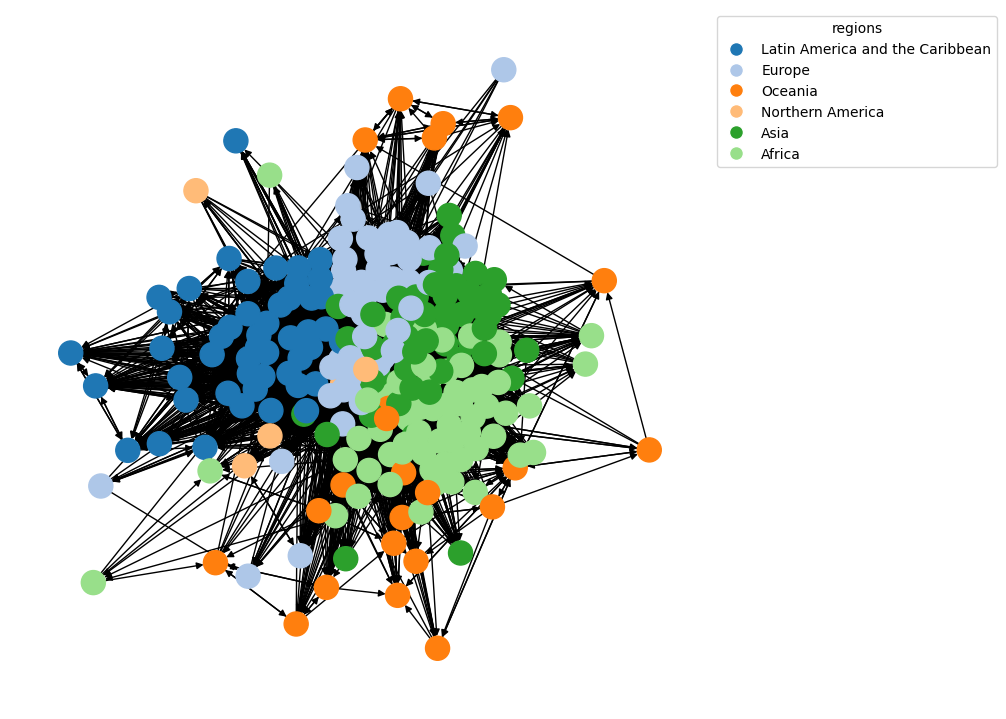

In [29]:

plt.figure(figsize=(7, 7))
pos = nx.spring_layout(g)  # or any other layout you prefer
nx.draw(g, pos, node_color=node_colors)

# Create a legend
region_patches = [plt.Line2D([0], [0], marker='o', color='w', label=region,
                          markerfacecolor=color, markersize=10)
                     for region, color in color_map.items()]
plt.legend(handles=region_patches, title="regions", loc='upper left', bbox_to_anchor=(1, 1))
# plt.subplots_adjust(right=0.8)
# Show the plot
plt.show()

In [30]:
nn = nx.number_of_nodes(g)
ne = nx.number_of_edges(g)
print("Number of nodes: ", nn)
print("Number of edges: ",  ne)

Number of nodes:  232
Number of edges:  11228


In [31]:
density = nx.density(g)
weakly_connected = nx.is_weakly_connected(g)
strongly_connected = nx.is_strongly_connected(g)

print("Density:", density)
print("The graph", "is" if weakly_connected else "isn't" , "weakly connected")
print("The graph", "is" if strongly_connected else "isn't" , "strongly connected")

Density: 0.20950888192267503
The graph is weakly connected
The graph isn't strongly connected


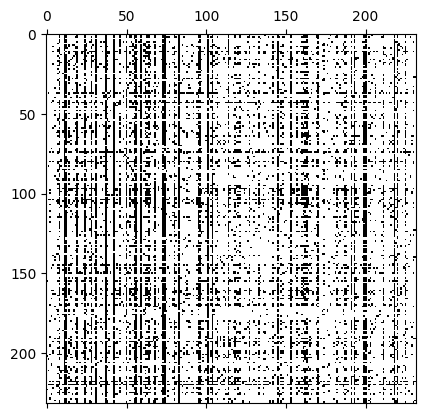

In [32]:
adj_matrix = nx.adjacency_matrix(g)
plt.spy(adj_matrix.todense())
plt.show()

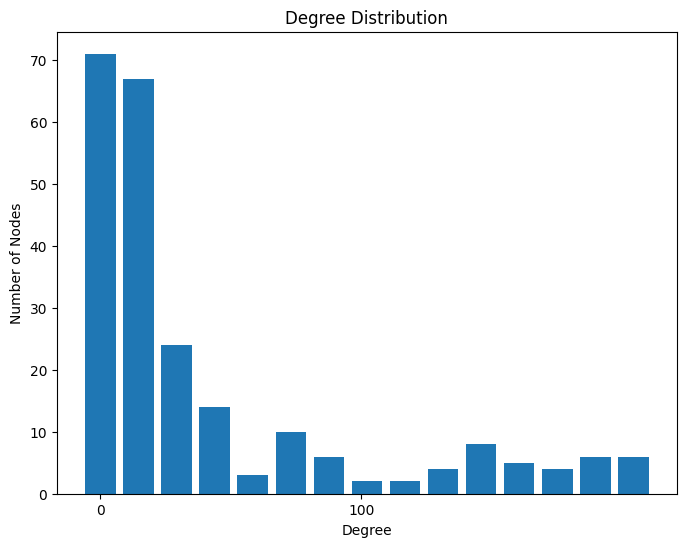

In [15]:
out_degrees = [degree for node, degree in g.out_degree]
in_degrees = [degree for node, degree in g.in_degree]

plt.figure(figsize=(8, 6))
plt.hist(in_degrees, align='left', rwidth=0.8, bins = "auto")
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.xticks(range(0, max(out_degrees) + 1, 100))
plt.show()

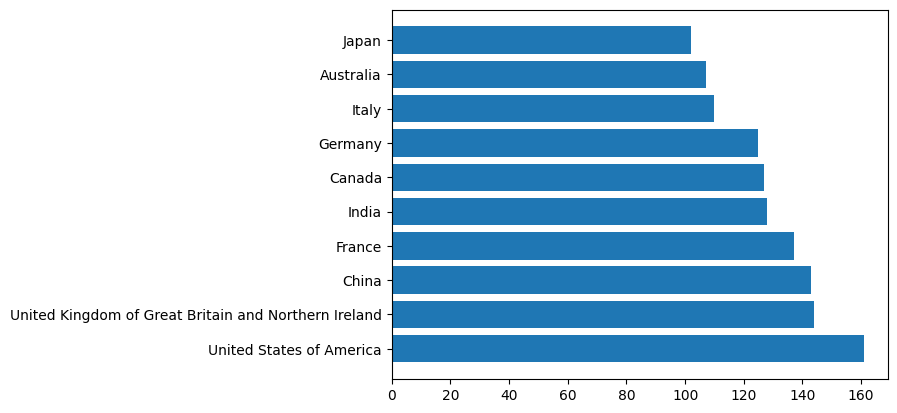

In [24]:
sorted_outd = sorted(g.out_degree(), key=lambda x:x[1], reverse = True)
plt.barh([g.nodes[id].get("name") for id, _ in sorted_outd[:10]], [value for _, value in sorted_outd[:10]])
plt.show()

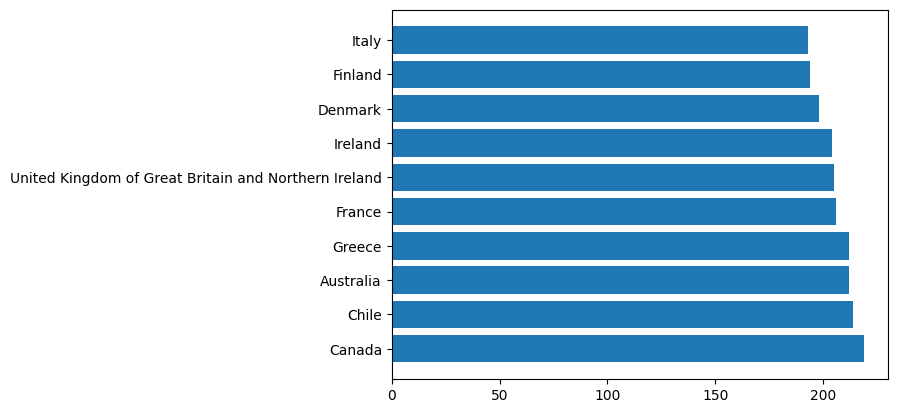

In [25]:
sorted_ind = sorted(g.in_degree(), key=lambda x:x[1], reverse = True)
plt.barh([g.nodes[id].get("name") for id, _ in sorted_ind[:10]], [value for _, value in sorted_ind[:10]])
plt.show()

## Centralities

In [40]:
centralities = {}
centralities["degree"] = nx.degree_centrality(g)
centralities["betweenness"] = nx.betweenness_centrality(g)
centralities["closeness"] = nx.closeness_centrality(g)
# centralities["katz"] = nx.katz_centrality(g)
centralities["eigen"] = nx.eigenvector_centrality(g)

In [33]:
def get_top(centrality, n = 10):
    sorted_centrality = list((({k: v for k, v in sorted(centrality.items(), key = lambda item: item[1], reverse = True)}).items()))
    return sorted_centrality[:n]
    

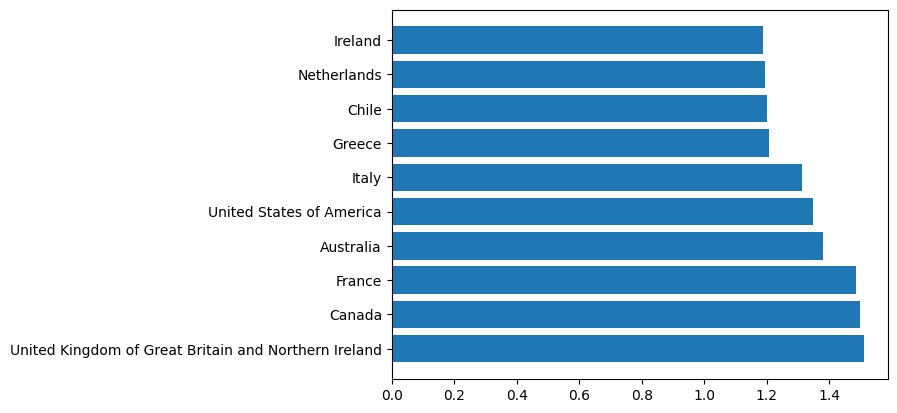

In [37]:
top10 = get_top(centralities["degree"], 10)
plt.barh([g.nodes[id].get("name") for id, _ in top10], [value for _, value in top10])
plt.show()